# Binary Classification on Tabular Data - Predicting Abnormal ECG Scans



[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/noportman/noportman.github.io/blob/main/docs/notebooks/02_binary_classification.ipynb)

## Introduction

In this notebook, you will train an autoencoder to detect anomalies on the ECG5000 dataset. This dataset contains 5,000 Electrocardiograms, each with 140 data points. You will use a simplified version of the dataset, where each example has been labeled either 0 (corresponding to an abnormal rhythm), or 1 (corresponding to a normal rhythm). You are interested in identifying the abnormal rhythms.

## Technical preliminaries

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# initialize the seeds of different random number generators so that the
# results will be the same every time the notebook is run
tf.random.set_seed(42)

pd.options.mode.chained_assignment = None

## Read in the data

Conveniently, the dataset in CSV form has been made available online and we can load it into a Pandas dataframe with the very useful `pd.read_csv` command.

In [ ]:
# Because each column of data represents a datapoint we will name the columns by the sequence of datapoints
# (1,2,3...140)
names = []
for i in range(140):
    names.append(i)
# The last column will be the target or dependent variable
names.append("Target")

Read in the data from http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv and set the column names from the list created in the box above

In [ ]:
df = pd.read_csv(
    "http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv", header=None
)

df.columns = names

In [ ]:
df.shape

(4998, 141)

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,Target
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


## Preprocessing

This dataset only has numeric variables. For consistency sake, we will assign the column names to variable numerics.


In [ ]:
numerics = names

# Remove the dependent variable
numerics.remove("Target")

In [ ]:
# Set the output to "target_metrics"
target_metrics = df.Target.value_counts(normalize=True)
print(target_metrics)

Target
1.0    0.584034
0.0    0.415966
Name: proportion, dtype: float64


Extract the dependent variable

In [ ]:
# set the dependent variables to 'y'
y = df.pop("Target")


Before we normalize the numerics, let's split the data into an 80% training set and 20% test set (*why should we split **before** normalization?*).

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# split into train and test sets with the following naming conventions:
# X_train, X_test, y_train and y_test
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, stratify=y)

OK, let's calculate the mean and standard deviation of every numeric variable in the training set.

In [ ]:
# Assign the means to "means" and standard deviation to "sd"
means = X_train[numerics].mean()
sd = X_train[numerics].std()
print(means)

0     -0.259974
1     -1.649012
2     -2.494121
3     -3.123972
4     -3.174288
         ...   
135   -0.748861
136   -0.824043
137   -0.634293
138   -0.476624
139   -0.696533
Length: 140, dtype: float64


Let's normalize the train and test dataframes with these means and standard deviations.

In [ ]:
# Normalize X_train
X_train[numerics] = (X_train[numerics] - means) / sd

In [ ]:
# Normalize X_test
X_test[numerics] = (X_test[numerics] - means) / sd

In [ ]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
427,0.580899,0.793618,0.918673,0.737492,0.292761,-0.232640,-0.861858,-1.226596,-1.001905,-0.915771,...,-1.020064,-1.161288,-1.142626,-1.214792,-1.357472,-1.254143,-1.006778,-0.636880,-0.210508,0.549730
2966,1.441951,2.067601,1.272848,0.663470,0.041595,-0.998269,-1.574790,-0.859452,-0.546192,-1.260566,...,-0.024950,0.188150,0.520326,0.630011,0.938034,1.181414,1.258041,1.361043,1.014476,1.841050
1519,-1.497090,-1.460123,-1.305122,-0.988272,-0.111905,0.909222,0.945581,0.979255,1.695861,1.070790,...,1.198161,1.081295,0.776457,0.652695,0.566349,0.422335,0.257221,0.188846,0.463857,0.061716
1509,-0.205527,0.122076,-0.011031,-0.301159,-0.876628,-0.880938,-0.836241,-0.412670,-0.546643,-0.778561,...,0.984222,0.945076,0.949485,1.059770,1.085176,1.010766,0.841484,0.680756,0.632651,0.474864
4066,-0.332154,-0.316098,-0.555610,-0.362139,-0.257697,-0.332715,-0.456818,0.028478,0.356281,-0.268661,...,-0.102338,-0.405098,-0.596766,-0.705521,-0.794454,-1.082549,-1.165394,-0.991427,-0.337909,0.705200


The easiest way to feed data to Keras/Tensorflow is as Numpy arrays so we convert our two dataframes to Numpy arrays.

In [ ]:
# Convert X_train and X_test to Numpy arrays
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

In [ ]:
X_train.shape, y_train.shape

((3998, 140), (3998,))

In [ ]:
X_test.shape, y_test.shape

((1000, 140), (1000,))

## Build a model

### Define model in Keras

Creating an NN  is usually just a few lines of Keras code.

* We will start with a single hidden layer.
* Since this is a *binary classification problem*, we will use a sigmoid activation in the output layer.

In [ ]:
# get the number of columns and assign it to "num_columns"

num_columns = X_train.shape[1]

# Define the input layer. assign it to "input"
input = keras.Input(shape=(num_columns,), dtype="float32")

# Feed the input vector to the hidden layer. Call it "h"
h = keras.layers.Dense(16, activation="relu", name="Hidden")(input)

# Feed the output of the hidden layer to the output layer. Call it "output"
output = keras.layers.Dense(1, activation="sigmoid", name="Output")(h)

# tell Keras that this (input,output) pair is your model. Call it "model"
model = keras.Model(input, output)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 140)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden (Dense)                  │ (None, 16)             │         2,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,273 (8.88 KB)

 Trainable params: 2,273 (8.88 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

### Set optimization parameters

Now that the model is defined, we need to tell Keras three things:

*   What **loss function** to use - Since our output variable is binary, we will select the `binary_crossentropy` loss function.
*   Which **optimizer** to use - we will use a 'flavor' of SGD called `adam` which is an excellent default choice
*   What **metrics** you want Keras to report out - in classification problems like this one, `accuracy` is commonly used.

In [ ]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

## Train the model

To kickoff training, we have to decide on three things:
* The *batch size* - 32 is a good default
* The number of *epochs* (i.e., how many passes through the training data). Start by setting this to 100, but you can experiment with different values.
* Whether we want to use a validation set. This will be useful for overfitting detection and regularization via early stopping so we will ask Keras to automatically use 20% of the data points as a validation set

In [ ]:
# Fit your model and assign the output to "history"
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=2)

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

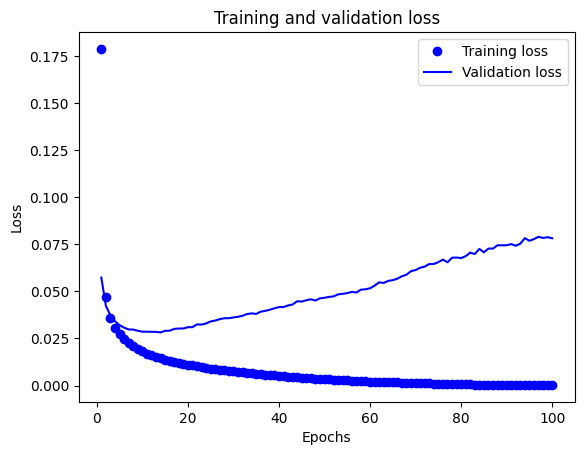

In [ ]:
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

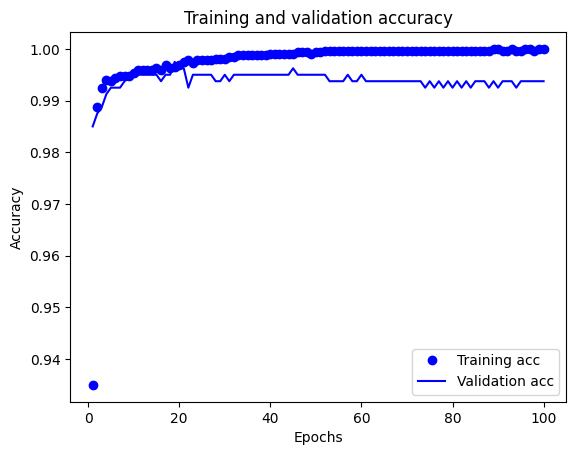

In [ ]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Evaluate the model

Let's see **how well the model does on the test set**.

`model.evaluate` is a very handy function to calculate the performance of your model on any dataset.

In [ ]:
# Getting the results of your model for grading
score, acc = model.evaluate(X_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9899 - loss: 0.0742      


In [ ]:
y.value_counts(normalize=True)

,proportion
Target,
1.0,0.584034
0.0,0.415966


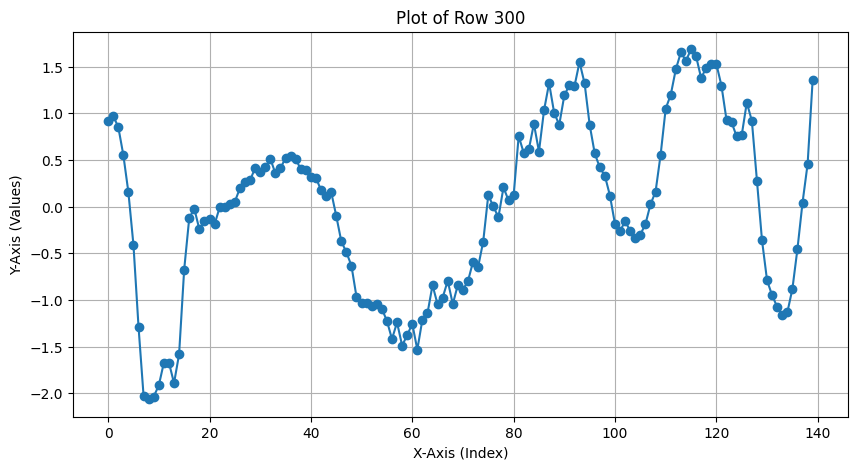

In [ ]:
# Selecting a specific row (e.g., row index 300)
row_index = 300
y_values = X_train[row_index, :]
x_values = range(X_train.shape[1])  # X-axis: 0 to 139

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(x_values, y_values, marker="o", linestyle="-")
plt.xlabel("X-Axis (Index)")
plt.ylabel("Y-Axis (Values)")
plt.title(f"Plot of Row {row_index}")
plt.grid(True)
plt.show()

In [ ]:
print(y_train[row_index]) # Result is abnormal scan for row_index=300

0.0
